In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0267

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - loss: 0.0185
Average validation loss: 0.6406794786453247
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - loss: 0.0185 - val_loss: 0.6407
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 496ms/step - loss: 0.0125 - val_loss: 0.6407
Average validation loss: 0.39810827374458313
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step - loss: 0.0125 - val_loss: 0.5194
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step - loss: 0.0091 - val_loss: 0.5194
Average validation loss: 0.34858497977256775
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 541ms/step - loss: 0.0091 - val_loss: 0.4625
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 802ms/step - loss: 7.2535e-06
Average validation loss: 0.19366009905934334
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 815ms/step - loss: 7.2535e-06 - val_loss: 0.1937
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 779ms/step - loss: 7.2134e-06 - val_loss: 0.1937
Average validation loss: 0.37031271308660507
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 789ms/step - loss: 7.2134e-06 - val_loss: 0.2820
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 820ms/step - loss: 7.0673e-06 - val_loss: 0.2820
Average validation loss: 0.3081844002008438
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 829ms/step - loss: 7.0673e-06 - val_loss: 0.2907
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 797ms/step - loss: 6.9499e-06 - val_loss: 0.2907
Average validation loss: 0.30505943298339844
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 809ms/step - loss: 6.9499e-06 - val_loss: 0.2943
Epoch 5/10
8/8 ━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 788ms/step - loss: 3.7546e-06
Average validation loss: 0.15139220654964447
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 802ms/step - loss: 3.7546e-06 - val_loss: 0.1514
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 776ms/step - loss: 3.8212e-06 - val_loss: 0.1514
Average validation loss: 0.16666974872350693
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 786ms/step - loss: 3.8212e-06 - val_loss: 0.1590
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 782ms/step - loss: 3.4436e-06 - val_loss: 0.1590
Average validation loss: 0.2675892512003581
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 796ms/step - loss: 3.4436e-06 - val_loss: 0.1952
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 844ms/step - loss: 3.3859e-06 - val_loss: 0.1952
Average validation loss: 0.07614269790550073
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 856ms/step - loss: 3.3859e-06 - val_loss: 0.1654
Saved model

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 841ms/step - loss: 6.6704e-07
Average validation loss: 0.04259605263359845
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 852ms/step - loss: 6.6704e-07 - val_loss: 0.0426
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 793ms/step - loss: 6.1213e-07 - val_loss: 0.0426
Average validation loss: 0.02946665429044515
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 807ms/step - loss: 6.1213e-07 - val_loss: 0.0360
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 774ms/step - loss: 5.6084e-07 - val_loss: 0.0360
Average validation loss: 0.045001598075032234
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 787ms/step - loss: 5.6084e-07 - val_loss: 0.0390
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 822ms/step - loss: 5.1786

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 843ms/step - loss: 5.9054e-07
Average validation loss: 0.04947326090186834
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 853ms/step - loss: 5.9054e-07 - val_loss: 0.0495
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 846ms/step - loss: 4.5253e-07 - val_loss: 0.0495
Average validation loss: 0.036572142690420154
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 859ms/step - loss: 4.5253e-07 - val_loss: 0.0430
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 784ms/step - loss: 3.7134e-07 - val_loss: 0.0430
Average validation loss: 0.023643871303647757
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 799ms/step - loss: 3.7134e-07 - val_loss: 0.0366
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\w

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 771ms/step - loss: 5.1533e-07
Average validation loss: 0.035270673028814294
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 781ms/step - loss: 5.1533e-07 - val_loss: 0.0353
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 777ms/step - loss: 4.3976e-07 - val_loss: 0.0353
Average validation loss: 0.026238528390725453
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 787ms/step - loss: 4.3976e-07 - val_loss: 0.0308
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 780ms/step - loss: 4.0187e-07 - val_loss: 0.0308
Average validation loss: 0.02784759714268148
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 790ms/step - loss: 4.0187e-07 - val_loss: 0.0298
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 778ms/step - loss: 3.821

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 840ms/step - loss: 6.4923e-07
Average validation loss: 0.020215772686060517
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 853ms/step - loss: 6.4923e-07 - val_loss: 0.0202
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 779ms/step - loss: 5.8511e-07 - val_loss: 0.0202
Average validation loss: 0.02836249228566885
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 791ms/step - loss: 5.8511e-07 - val_loss: 0.0243
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 775ms/step - loss: 4.8922e-07 - val_loss: 0.0243
Average validation loss: 0.03145387318218127
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 787ms/step - loss: 4.8922e-07 - val_loss: 0.0267
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 128s 780ms/step - loss: 4.1688e-07 - val_loss: 0.0267
Average validation loss: 0.0260824530152604
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 793ms/step - loss: 4.1688e-07 - val_loss: 0.0265
Epoch 5

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 778ms/step - loss: 2.5410e-07
Average validation loss: 0.04457051830831915
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 791ms/step - loss: 2.5410e-07 - val_loss: 0.0446
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 867ms/step - loss: 2.5031e-07 - val_loss: 0.0446
Average validation loss: 0.013098540395731106
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 879ms/step - loss: 2.5031e-07 - val_loss: 0.0288
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 794ms/step - loss: 2.1168e-07 - val_loss: 0.0288
Average validation loss: 0.014915495543391444
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 806ms/step - loss: 2.1168e-07 - val_loss: 0.0242
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 157s 792ms/step - loss: 1.

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 849ms/step - loss: 1.1287e-07
Average validation loss: 0.01914443158810692
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 862ms/step - loss: 1.1287e-07 - val_loss: 0.0191
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 812ms/step - loss: 1.0539e-07 - val_loss: 0.0191
Average validation loss: 0.015155588110376681
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 825ms/step - loss: 1.0539e-07 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 843ms/step - loss: 9.6530e-08 - val_loss: 0.0172
Average validation loss: 0.019017288561112115
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 856ms/step - loss: 9.6530e-08 - val_loss: 0.0178
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 191s 854ms/step - loss: 9.

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 833ms/step - loss: 1.0556e-07
Average validation loss: 0.016241318255197257
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 845ms/step - loss: 1.0556e-07 - val_loss: 0.0162
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 785ms/step - loss: 8.4276e-08 - val_loss: 0.0162
Average validation loss: 0.014299261514679529
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 797ms/step - loss: 8.4276e-08 - val_loss: 0.0153
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 799ms/step - loss: 7.3802e-08 - val_loss: 0.0153
Average validation loss: 0.015943681239150465
64/64 ━━━━━━━━━━━━━━━━━━━━ 157s 811ms/step - loss: 7.3802e-08 - val_loss: 0.0155
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 208s 793ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 795ms/step - loss: 7.3325e-08
Average validation loss: 0.019760203314945102
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 806ms/step - loss: 7.3325e-08 - val_loss: 0.0198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 783ms/step - loss: 6.0287e-08 - val_loss: 0.0198
Average validation loss: 0.015170991271992939
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 794ms/step - loss: 6.0287e-08 - val_loss: 0.0175
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 786ms/step - loss: 5.2006e-08 - val_loss: 0.0175
Average validation loss: 0.020300751810686454
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 796ms/step - loss: 5.2006e-08 - val_loss: 0.0184
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 232s 832ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 789ms/step - loss: 9.7600e-08
Average validation loss: 0.018491258221911267
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 800ms/step - loss: 9.7600e-08 - val_loss: 0.0185
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 782ms/step - loss: 7.3105e-08 - val_loss: 0.0185
Average validation loss: 0.011850546213099732
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 793ms/step - loss: 7.3105e-08 - val_loss: 0.0152
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 201s 915ms/step - loss: 6.4691e-08 - val_loss: 0.0152
Average validation loss: 0.015578169730724767
80/80 ━━━━━━━━━━━━━━━━━━━━ 202s 926ms/step - loss: 6.4691e-08 - val_loss: 0.0153
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 269s 847ms/step - los

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 80s 836ms/step - loss: 1.0896e-07
Average validation loss: 0.021951323016158614
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 848ms/step - loss: 1.0896e-07 - val_loss: 0.0220
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 157s 783ms/step - loss: 8.3237e-08 - val_loss: 0.0220
Average validation loss: 0.022231823968468234
96/96 ━━━━━━━━━━━━━━━━━━━━ 158s 794ms/step - loss: 8.3237e-08 - val_loss: 0.0221
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 233s 781ms/step - loss: 6.8678e-08 - val_loss: 0.0221
Average validation loss: 0.024123130191583186
96/96 ━━━━━━━━━━━━━━━━━━━━ 234s 792ms/step - loss: 6.8678e-08 - val_loss: 0.0228
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 308s 774ms/step - loss: 6.1624e-08 - val_loss: 0.0228
Average validation loss: 0.023101246789641056
96/96 ━━━━━━━━━━━━━━━━━━━━ 309s 785ms/step - loss: 6.1624e-08 - val_loss: 0.022

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 795ms/step - loss: 2.7641e-07
Average validation loss: 0.02371156665806969
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 807ms/step - loss: 2.7641e-07 - val_loss: 0.0237
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 191s 783ms/step - loss: 3.2952e-07 - val_loss: 0.0237
Average validation loss: 0.036019225441850725
120/120 ━━━━━━━━━━━━━━━━━━━━ 192s 794ms/step - loss: 3.2952e-07 - val_loss: 0.0299
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 287s 792ms/step - loss: 4.6753e-07 - val_loss: 0.0299
Average validation loss: 0.02816803422756493
120/120 ━━━━━━━━━━━━━━━━━━━━ 289s 803ms/step - loss: 4.6753e-07 - val_loss: 0.0293
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 384s 795ms/step - loss: 4.1741e-07 - val_loss: 0.0293
Average validation loss: 0.07627011601192256
120/120 ━━━━━━━━━━━━━━━━━━━━ 385s 806ms/step - loss: 4.1741e-07 - va

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 796ms/step - loss: 1.9761e-07
Average validation loss: 0.018652282357733283
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 807ms/step - loss: 1.9761e-07 - val_loss: 0.0187
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 805ms/step - loss: 1.4413e-07 - val_loss: 0.0187
Average validation loss: 0.02252499707780468
144/144 ━━━━━━━━━━━━━━━━━━━━ 234s 816ms/step - loss: 1.4413e-07 - val_loss: 0.0206
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 804ms/step - loss: 1.2346e-07 - val_loss: 0.0206
Average validation loss: 0.023061206050139543
144/144 ━━━━━━━━━━━━━━━━━━━━ 351s 815ms/step - loss: 1.2346e-07 - val_loss: 0.0214
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 465s 789ms/step - loss: 1.0801e-07 - val_loss: 0.0214
Average validation loss: 0.022304786873670917
144/144 ━━━━━━━━━━━━━━━━━━━━ 466s 800ms/step - loss: 1.0801e-07 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 131s 818ms/step - loss: 9.8709e-08
Average validation loss: 0.020147052151151
160/160 ━━━━━━━━━━━━━━━━━━━━ 133s 830ms/step - loss: 9.8709e-08 - val_loss: 0.0201
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 262s 811ms/step - loss: 7.7733e-08 - val_loss: 0.0201
Average validation loss: 0.027339580340776593
160/160 ━━━━━━━━━━━━━━━━━━━━ 264s 823ms/step - loss: 7.7733e-08 - val_loss: 0.0237
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 392s 802ms/step - loss: 6.7647e-08 - val_loss: 0.0237
Average validation loss: 0.02090955416788347
160/160 ━━━━━━━━━━━━━━━━━━━━ 394s 813ms/step - loss: 6.7647e-08 - val_loss: 0.0228
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 531s 858ms/step - loss: 6.0538e-08 - val_loss: 0.0228
Average validation loss: 0.021262606291566045
160/160 ━━━━━━━━━━━━━━━━━━━━ 533s 869ms/step - loss: 6.0538e-08 - v

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 811ms/step - loss: 1.1144e-07
Average validation loss: 0.031349741635785904
200/200 ━━━━━━━━━━━━━━━━━━━━ 164s 822ms/step - loss: 1.1144e-07 - val_loss: 0.0313
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 323s 792ms/step - loss: 1.0381e-07 - val_loss: 0.0313
Average validation loss: 0.021793842334882355
200/200 ━━━━━━━━━━━━━━━━━━━━ 325s 803ms/step - loss: 1.0381e-07 - val_loss: 0.0266
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 483s 791ms/step - loss: 9.0446e-08 - val_loss: 0.0266
Average validation loss: 0.022480791113339366
200/200 ━━━━━━━━━━━━━━━━━━━━ 485s 802ms/step - loss: 9.0446e-08 - val_loss: 0.0252
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 641s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 795ms/step - loss: 7.8434e-07
Average validation loss: 0.034601484414694524
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 807ms/step - loss: 7.8434e-07 - val_loss: 0.0346
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 381s 780ms/step - loss: 8.4162e-07 - val_loss: 0.0346
Average validation loss: 0.0478316114594539
240/240 ━━━━━━━━━━━━━━━━━━━━ 384s 791ms/step - loss: 8.4162e-07 - val_loss: 0.0412
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 570s 778ms/step - loss: 7.8419e-07 - val_loss: 0.0412
Average validation loss: 0.11548166253538679
240/240 ━━━━━━━━━━━━━━━━━━━━ 573s 788ms/step - loss: 7.8419e-07 - val_loss: 0.0660
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 764s 799ms/step - loss: 7.1967e-07 - val_loss: 0.0660
Average validation loss: 0.05452476890350226
240/240 ━━━━━━━━━━━━━━━━━━━━ 767s 810ms/step - loss: 7.1967e-07 - v

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.20191379234194756, 0.13865137185901402, 0.08254773572708168, 0.030871077668853105, 0.022750966437393796, 0.01747595964174252, 0.02697739197104238, 0.024077036485638623, 0.01332749190016849, 0.01281719540762424, 0.013203707235354361, 0.011113948164333122, 0.015057834764229483, 0.02140082138260671, 0.02001490580871986, 0.01891391456499696, 0.023423859015543714, 0.03140990632034241]
std_val_losses =  [0.13308378804906773, 0.08851245429297562, 0.04966754301073179, 0.012656383726357814, 0.0104863129966342, 0.006722798334430304, 0.01412198908184654, 0.018788448286139424, 0.0048673553997385785, 0.002962325981276653, 0.004170642475115892, 0.0024753648655584143, 0.004703015160042376, 0.009183713955565675, 0.0037503537520069525, 0.003164824251707762, 0.01510110417372618, 0.01693027971274247]


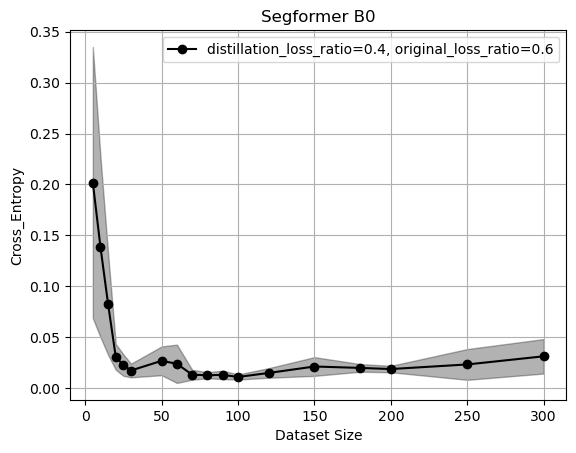

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()